# PyStan Practice
## Binomial distribution 

Christa Caggiano, Zaitlen Lab, Dec 2018 


**Sources:** [*Bayesian Data Analysis*](https://the-eye.eu/public/Books/qt.vidyagam.es/library/Monitoring%20and%20Analysis/Bayesian%20Data%20Analysis%2C%20Third%20Edition/Bayesian%20Data%20Analysis%2C%20Third%20Edition%20-%20Andrew%20Gelman%20%26%20John%20B.%20Carlin%20%26%20Hal%20S.%20Stern%20%26%20David%20B.%20Dunson%20%26%20Aki%20Vehtari%20%26%20Donald%20B.%20Rubin.pdf), [World Bank Sex Rate at Birth Dataset](https://data.worldbank.org/indicator/SP.POP.BRTH.MF), [US government birth data](https://catalog.data.gov/dataset?tags=births), [Human Sex Ratio](https://en.wikipedia.org/wiki/Human_sex_ratio)

### Imports

In [1]:
import pystan 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import scipy

### Generate Simulated Data

In [115]:
# generate simulated data in an imaginary coin toss scenario  

n = 100  # number of flips 
p = 0.5  # probability of heads 
size = 1000 # number of trials

heads = np.random.binomial(n, p, size)
ratio_heads = heads/(n-heads)

### Plot simulated data

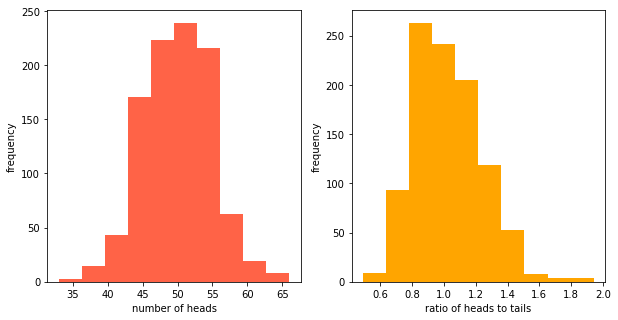

In [37]:
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(10, 5))  # multiple plots on one axis

axes[0].hist(heads, color="tomato")
axes[0].set_xlabel("number of heads")
axes[0].set_ylabel("frequency")

axes[1].hist(ratio_heads, color="orange")
axes[1].set_xlabel("ratio of heads to tails")
axes[1].set_ylabel("frequency")

plt.show()

### Define model 

In [4]:
# define model as a simple binomial 

binomial = """
data {
    // input to model fitting 
    int<lower=1> n; // number of trials
    int<lower=1> s; // number of trial attempts
    int y[s]; // observations 
}
parameters {
    // parameters to estimate 
    real<lower=0,upper=1> p; // estimate the probability of success 
}
model {
    y ~ binomial(n, p); // model y given number of trials and observations  
}
"""

In [5]:
binomial_model = pystan.StanModel(model_code=binomial)  # linear regression model 1 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5eb3807b5a4c3a8d2c9f3679b2d5b96d NOW.
/Users/Christa.Caggiano/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/m4/h85zk1hs5kzcdnmhsppglh2m0000gn/T/tmpm6jqoejk/stanfit4anon_model_5eb3807b5a4c3a8d2c9f3679b2d5b96d_8426403865361471869.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [131]:
data = {"y":heads, "n":n, "s":size}  # input data as a dictionary 
fit1 = binomial_model.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)  # fit model  

RuntimeError: Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=n; dims declared=(1000); dims found=()  (in 'unknown file name' at line 6)


### Summarize Model 

In [7]:
summary_dict1 = fit1.summary()  # summarize data 
summary1 = pd.DataFrame(summary_dict1["summary"], columns=summary_dict1["summary_colnames"], index=summary_dict1["summary_rownames"]) 

In [130]:
summary1

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
p,5.117106e-01,0.000009,0.000256,5.111937e-01,5.115396e-01,5.117170e-01,5.118873e-01,5.121959e-01,746.172183,1.002159
lp__,-2.671374e+06,0.024830,0.679908,-2.671376e+06,-2.671374e+06,-2.671374e+06,-2.671374e+06,-2.671373e+06,749.775004,1.000536


### Plot parameter estimate

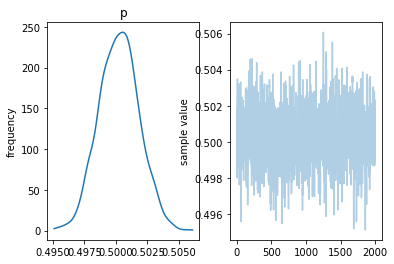

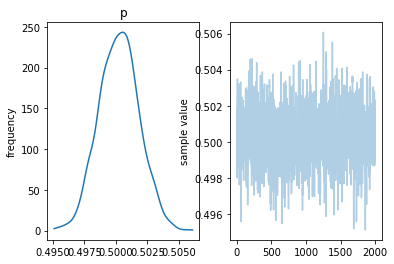

In [12]:
# uses pystan's built in plotting function to look at traces of p estimated 

fit1.plot()

### Load Real Data

I wanted to see how well the model would do when I gave it simple real data that was approximately binomial. Used the US government natality data by state for 2017. 

In [153]:
# load in data included in the repository 

births = pd.read_table("../data/natality-by-state.txt")

### Subset Dataframes 

In [36]:
# make an individual dataframe for male and female birth counts 

male_births = births[births["Gender Code"] == "M"]
female_births = births[births["Gender Code"] == "F"]

In [51]:
# make numpy arrays for easier computation and because I think pystan requires this 

male_counts = male_births["Births"].values
female_counts = female_births["Births"].values

In [63]:
# calculate the ratio of male:female births 

male_ratio = male_counts/female_counts
male_ratio_avg = male_ratio.mean()

In [62]:
# calculate what percentage males are of the total birth 

male_rate = male_counts/(male_counts + female_counts)
male_rate_avg = male_rate.mean()  # this number is ~0.51 which seems in line with wikipedia's estimate of male birth rate 

### Plot 

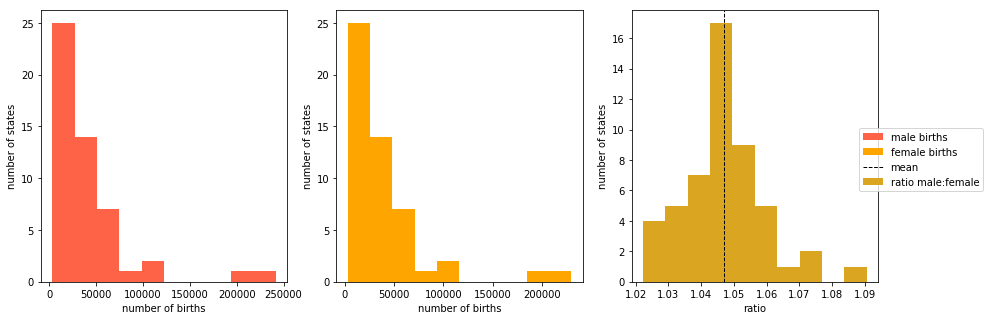

In [102]:
# plot the counts and the ratio of male to female births to see if it looks validly binomial 

fig, axes = plt.subplots(1, 3, sharey=False, figsize=(15, 5))

axes[0].hist(male_counts, color="tomato", label="male births") 
axes[1].hist(female_counts, color="orange", label="female births")
axes[2].hist(male_ratio, color="goldenrod", label="ratio male:female")
axes[2].axvline(male_ratio_avg, color="black", linestyle="dashed", linewidth=1, label="mean")

axes[0].set_ylabel("number of states")
axes[1].set_ylabel("number of states")
axes[2].set_ylabel("number of states")

axes[0].set_xlabel("number of births")
axes[1].set_xlabel("number of births")
axes[2].set_xlabel("ratio")

fig.legend(loc=5)
plt.show()

*It seems that the count data is a little skewed by states with really high or low relative number of births (ie California versus like Idaho), but the ratios look reasonable* 

### Redefine model

In [120]:
# define the binomial model same as above, but this time to allow a variable number of trials, otherwise keep the same 

binomial = """
data {
    // input to model fitting 
    int<lower=1> s; 
    int y[s]; 
    int<lower=1> n[s]; // number of trials

}
parameters {
    // parameters to estimate 
    real<lower=0,upper=1> p; 
}
model {
    y ~ binomial(n, p); // model w normal distribution 
}
"""

### Recompile model 

In [121]:
binomial_model = pystan.StanModel(model_code=binomial)  

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e365189241b1cdd985b614e36adf2f2d NOW.
/Users/Christa.Caggiano/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/m4/h85zk1hs5kzcdnmhsppglh2m0000gn/T/tmpc_29gww1/stanfit4anon_model_e365189241b1cdd985b614e36adf2f2d_1154920285982594827.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Model 

In [122]:
# make the data into easy numpy arrays 

male = male_counts 
total = (male_counts+female_counts)

In [123]:
data = {"y":male, "n":total, "s":len(male)}  # define data in a dictionary 
fit2 = binomial_model.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)  # run model 

### Summarize model 

In [128]:
summary_dict2 = fit2.summary()
summary2 = pd.DataFrame(summary_dict2["summary"], columns=summary_dict2["summary_colnames"], index=summary_dict2["summary_rownames"]) 

In [129]:
summary2

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
p,5.117106e-01,0.000009,0.000256,5.111937e-01,5.115396e-01,5.117170e-01,5.118873e-01,5.121959e-01,746.172183,1.002159
lp__,-2.671374e+06,0.024830,0.679908,-2.671376e+06,-2.671374e+06,-2.671374e+06,-2.671374e+06,-2.671373e+06,749.775004,1.000536


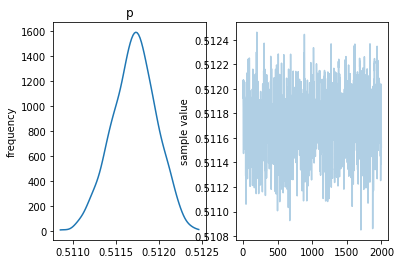

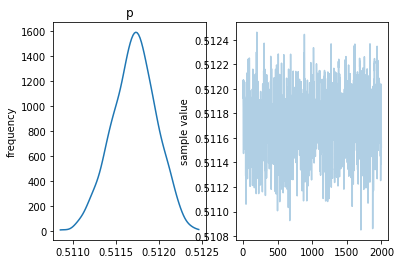

In [125]:
# plot iteration traces 

fit2.plot()

In [154]:
# get the estimates for the proportion of male births and the average estimate 
# also get 95% confidence interval 

p_est_avg = summary2["mean"]["p"]
p_est_lower = summary2["2.5%"]["p"]
p_est_upper = summary2["97.5%"]["p"]

p_est = fit2["p"] 

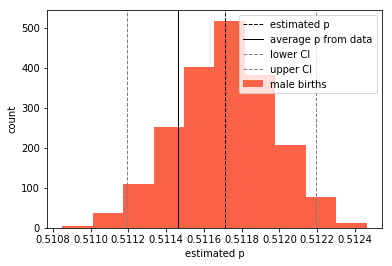

In [156]:
# plot the estimates of p along with a 95% confidence interval, and the estimate of p I calculated from the data 

plt.hist(p_est, color="tomato", label="male births") 
plt.axvline(p_est_avg, color="black", linestyle="dashed", linewidth=1, label="estimated p")
plt.axvline(male_rate_avg, color="black", linestyle="solid", linewidth=1, label="average p from data")
plt.axvline(p_est_lower, color="grey", linestyle="dashed", linewidth=1, label="lower CI")
plt.axvline(p_est_upper, color="grey", linestyle="dashed", linewidth=1, label="upper CI")

plt.xlabel("estimated p")
plt.ylabel("count")

plt.legend()
plt.show()

In [150]:
# difference between data average estimate and the model estimate 
p_est_avg - male_rate_avg

0.00024522686774941516

*Overall, the estimate was well within the  